# 업종 재분류

- 온라인,제외 삭제
- 유흥의 pc방, 노래방 -> 여가
- 차량의 신차/중고차/수입차 삭제  교통은 제외
- 여행 : 숙박시설 + 여행사 => 모텔,여관,기타숙박 , 호텔, 콘도미니엄 '숙박' 새로운 명 생성
- 쇼핑의 쇼핑몰/쇼핑센터, 패션/의류, 패션잡화 -> 유통으로
- 요식: 제과점, 커피전문점, 기타요식/식품 -> 커피제과 // 나머지는 요식
- 생활/서비스 + 인테리어

- New: '유통', '교육', '의료', '생활/서비스', '차량', '요식', '미용', '온라인', '쇼핑', '교통',
- Delete: '여가', '유흥', '여행', '인테리어', '제외'

# 데이터 전처리(데이터 센터에서 진행)

In [ ]:
# 업종 재분류를 통한 새로운 DataFrame 생성
import pandas as pd

for i in range(12,13):
    path = 'SH_DOMESTIC_IN_2023%d.txt' %i
    a = "data" + str(i)
    a = pd.read_csv(path, sep='|', encoding = 'cp949')

    data_sudo = a[(a['고객광역시도명']=='서울') | (a['고객광역시도명']=='경기') | (a['고객광역시도명']=='인천')]
    
    #data_sudo['업종분류'] = None
    
    data_sudo.loc[(data_sudo['업종대분류'] == '의료'), '업종분류'] = '의료'
    data_sudo.loc[(data_sudo['업종대분류'] == '교육'), '업종분류'] = '교육'
    data_sudo.loc[(data_sudo['업종대분류'] == '미용'), '업종분류'] = '미용'

    data_sudo.loc[(data_sudo['업종대분류'] == '생활/서비스'), '업종분류'] = '생활/서비스'
    data_sudo.loc[(data_sudo['업종대분류'] == '인테리어'), '업종분류'] = '생활/서비스'

    data_sudo.loc[(data_sudo['업종대분류'] == '유통'), '업종분류'] = '유통'
    data_sudo.loc[((data_sudo['업종대분류'] == '쇼핑') & (data_sudo['업종소분류'].isin(['쇼핑몰/쇼핑센터', '패션/의류', '패션잡화']))), '업종분류'] = '유통'

    data_sudo.loc[(data_sudo['업종대분류'] == '여가'), '업종분류'] = '여가'
    condition1 = ((data_sudo['업종대분류'] == '유흥') & (data_sudo['업종소분류'].isin(['PC방/비디오방/전화방', '노래방'])))
    data_sudo.loc[condition1, '업종분류'] = '여가'

    condition2 = ((data_sudo['업종대분류'] == '차량') & (data_sudo['업종소분류'].isin(['주유소', 'LPG', '차량용품/서비스'])))
    data_sudo.loc[condition2, '업종분류'] = '차량'

    condition3 = ((data_sudo['업종대분류'] == '여행') & (data_sudo['업종소분류'].isin(['모텔,여관,기타숙박' , '호텔', '콘도미니엄'])))
    data_sudo.loc[condition3, '업종분류'] = '숙박'

    condition4 = ((data_sudo['업종대분류'] == '요식') & (data_sudo['업종소분류'].isin(['제과점', '커피전문점', '기타요식/식품'])))
    data_sudo.loc[condition4, '업종분류'] = '커피/제과'

    condition4 = ((data_sudo['업종대분류'] == '요식') & (data_sudo['업종소분류'].isin([ '한식', '중식', '일반대중음식', '양식', '일식', '패스트푸드', '부페'])))
    data_sudo.loc[condition4, '업종분류'] = '요식'
    
    data_sudo = data_sudo[(data_sudo['업종대분류'] != '온라인') & (data_sudo['업종대분류'] != '제외') & (data_sudo['업종대분류'] != '교통')] 

    data_sudo = data_sudo.dropna()
    
    locals()['data_%d'%i] = data_sudo[['기준연월','고객광역시도명','고객시군구명','성별','연령대','결혼유무','가구유형','업종분류','카드이용금액','카드이용건수']]

In [ ]:
# 분기별로 시군구 이름 정리
def extract_region(address):
    parts = address.split()
    return parts[0]

data1_3['시군구']=data1_3['고객시군구명'].apply(extract_region) 

# 광역시별 전체 카드금액 합 구하기
sum_amt = data1_3.groupby(['업종분류', '고객광역시도명'])['카드이용금액'].sum().reset_index()
sum_amt.columns = ['업종분류','고객광역시도명','카드금액합']

# 기존 데이터에 (광역시별 전체 카드금액 합) 병합
data_1_3 = pd.merge(data1_3,sum_amt, on =['업종분류','고객광역시도명'])

# 시군구별 업종 카드금액 합 구하기
data_1_3 = data_1_3.groupby(['고객광역시도명','시군구','업종분류'])['카드이용금액'].sum().reset_index()


# 시군구별 정리 데이터 기존 데이터에 병합
data_1_3 = pd.merge(data_1_3,data, on =['업종분류','고객광역시도명','시군구'],how='right')

# 카드비율 (시군구별 업종 금액 / 광역시별 업종 금액)
data_1_3['업종_카드금액_시군구별_비율'] = data_1_3['카드이용금액_y'] / data_1_3['카드금액합']

# 필요한 컬럼 정리
data_1_3 = data_1_3[['기준연월','고객광역시도명','시군구','성별','연령대','결혼유무','가구유형','업종분류','카드이용금액_x','카드이용건수','업종_카드금액_시군구별_비율']]

# 최종 데이터 내보내기
data_1_3.to_csv('1분기_시군구별비율.csv')

In [ ]:
# 가장 최신 년도의 연령 분류
# 파일 읽어오는 코드 생략

bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['10s', '20s', '30s', '40s','50s','over 60s']

df_12['연령대_통합'] = pd.cut(df_12['연령대'], bins=bins, labels = labels, right=False)

df_12.to_csv('23_12_연령대.csv')

In [ ]:
# 연령 분류 시각화

plt.style.use('seaborn')
plt.rcParams['font.family'] = 'Malgun Gothic' 
df_ages.plot.barh(stacked=True, figsize=(15,9), color = ['#9e0142', '#d53e4f', '#f46d43', '#fdae61', '#fee08b', '#abdda4','#66c2a5','green', '#3288bd', '#5e4fa2']) 

plt.show()

In [ ]:
df_age_regions = da_12.pivot_table(index='연령대_통합', columns='시군구', values='카드이용건수',aggfunc='sum')

data = df_age_regions

total_usage_by_region=data.sum(axis=0)

#비율 변환
ratio_pivot_table = data.div(total_usage_by_region, axis=1)*100

# 연령별_지역별_카드사용량비율.csv
# ratio_pivot_table

In [ ]:
# 분기별 pivot table -> 분기_업종별_지역별_카드사용량비율.csv
a = df_01
#1분기
df_regions = a.pivot_table(index='업종분류', columns='시군구', values='카드이용건수',aggfunc='sum')

data = df_regions

# 백분율 표시
total_usage_by_region=data.sum(axis=0)

#비율 변환
ratio_pivot_table = data.div(total_usage_by_region, axis=1)*100
    
data_pivot_1 = ratio_pivot_table

# 각 업종 별 지역 카드사용 순위
data = data_pivot_1.transpose()
ranked_01 = data.rank(ascending=False, method='min')

# 랭킹 2위까지 추출
# best_ranked_01 = ranked_01.apply(lambda row: row.nsmallest(2), axis=1)

In [2]:
# 경기도, 인천의 분기별 지역별 카드소비_비율 1등을 지도를 통해 시각화 

import pandas as pd
import folium
import requests
import geopandas as gpd
from shapely.ops import unary_union

# Load the GeoJSON data
url = 'https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-municipalities-2018-geo.json'
response = requests.get(url)
data = response.json()

# Create GeoDataFrame from the GeoJSON data
gdf = gpd.GeoDataFrame.from_features(data['features'])
gdf.crs = "EPSG:4326"  # Set coordinate reference system to WGS84

# Load the Excel data directly into a pandas DataFrame
data_path = "data/순위_4분기_업종별_카드사용량.xlsx"
area_rankings = pd.read_excel(data_path, index_col=0)

# Identify the highest-ranked industry for each area
highest_ranked_industries = area_rankings.idxmin(axis=1)

# Define a simple color map for industries
industry_colors = {
    '교육': 'blue',
    '미용': 'red',
    '생활/서비스': 'green',
    '숙박': 'purple',
    '여가': 'orange',
    '요식': 'yellow',
    '유통': 'pink',
    '의료': 'teal',
    '차량': 'black',
    '커피/제과': 'brown'
}
# 시도 코드로 필터링 (서울: 11, 경기도: 31, 인천: 23)
codes = ['31', '23']
gdf_filtered = gdf[gdf['code'].str[:2].isin(codes)]
# Filter for Seoul only (code starts with '31')
#seoul_gdf = gdf[gdf['code'].str.startswith('31')]

# Merge data for specific areas (e.g., different areas of Seoul into one)
target_areas = ['용인시', '성남시', '안양시', '안산시', '수원시', '고양시']
for area in target_areas:
    area_data = gdf_filtered[gdf_filtered['name'].str.contains(area)]
    if not area_data.empty:
        unified_geometry = unary_union(area_data.geometry)
        new_row = gpd.GeoDataFrame({'name': [area], 'geometry': [unified_geometry]}, crs="EPSG:4326")
        # Remove individual area entries
        gdf_filtered = gdf_filtered[~gdf_filtered['name'].str.contains(area)]
        # Append the new unified area
        gdf_filtered = pd.concat([gdf_filtered, new_row], ignore_index=True)

# Create a map centered around Seoul
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# Add GeoJson data to the map with style based on the highest-ranked industry
folium.GeoJson(
    gdf_filtered,
    style_function=lambda feature: {
        'fillColor': industry_colors.get(highest_ranked_industries.get(feature['properties']['name'], 'grey'), 'grey'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['name'],
        aliases=['Region:'],
        localize=True 
    )
).add_to(m)

# Display the map in an interactive notebook environment
m


In [6]:
# 2023년 지역별 카드 소비연령 파악 후 시각화
import pandas as pd
import folium
import requests
import geopandas as gpd
from shapely.ops import unary_union

# Load the GeoJSON data from the URL
url = 'https://raw.githubusercontent.com/southkorea/southkorea-maps/master/kostat/2018/json/skorea-municipalities-2018-geo.json'
response = requests.get(url)
data = response.json()

# Create GeoDataFrame from the GeoJSON data
gdf = gpd.GeoDataFrame.from_features(data['features'])
gdf.crs = "EPSG:4326"  # Set coordinate reference system to WGS84

# Load the Excel data directly into a pandas DataFrame
data_path = "data/지역별_연령대.xlsx"
age_rankings = pd.read_excel(data_path)

# Define a simple color map for age groups
age_colors = {
    '10s': 'blue',
    '20s': 'red',
    '30s': 'green',
    '40s': 'purple',
    '50s': 'orange',
    'over 60s': 'yellow'
}

# Normalize the region names in GeoDataFrame and DataFrame
gdf['name'] = gdf['name'].str.replace(' ', '')
age_rankings['지역'] = age_rankings['지역'].str.replace(' ', '')

# 시도 코드로 필터링 (서울: 11, 경기도: 31, 인천: 23)
codes = ['11']
gdf_filtered = gdf[gdf['code'].str[:2].isin(codes)]

# Merge data for specific areas (e.g., different areas of Seoul into one)
target_areas = ['용인시', '성남시', '안양시', '안산시', '수원시', '고양시']
for area in target_areas:
    area_data = gdf_filtered[gdf_filtered['name'].str.contains(area)]
    if not area_data.empty:
        unified_geometry = unary_union(area_data.geometry)
        new_row = gpd.GeoDataFrame({'name': [area], 'geometry': [unified_geometry]}, crs="EPSG:4326")
        # Remove individual area entries
        gdf_filtered = gdf_filtered[~gdf_filtered['name'].str.contains(area)]
        # Append the new unified area
        gdf_filtered = pd.concat([gdf_filtered, new_row], ignore_index=True)

# Create a map centered around Seoul
m = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# Create a dictionary to map region names to age groups
region_to_age = dict(zip(age_rankings['지역'], age_rankings['연령대']))

# Debugging: Print out the mapping of area names to age groups
for area_name in gdf_filtered['name']:
    highest_age_group = region_to_age.get(area_name, 'Not Found')
    color = age_colors.get(highest_age_group, 'grey')
    # print(f"Area: {area_name}, Highest Age Group: {highest_age_group}, Color: {color}")

# Add GeoJson data to the map with style based on the highest-ranked age group
def style_function(feature):
    area_name = feature['properties']['name']
    highest_age_group = region_to_age.get(area_name, 'over 60s')  # Default to 'over 60s' if not found
    color = age_colors.get(highest_age_group, 'grey')
    # print(f"Feature: {area_name}, Highest Age Group: {highest_age_group}, Color: {color}")
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    }

folium.GeoJson(
    gdf_filtered,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['name'],
        aliases=['Region:'],
        localize=True 
    )
).add_to(m)

# Display the map in an interactive notebook environment
m


In [30]:
# 분기별로 업종 변화 excel 파일 정리
import pandas as pd

# Load the data from the provided files
data1 = "data/순위_1분기_업종별_카드사용량.xlsx"
data2 = "data/순위_2분기_업종별_카드사용량.xlsx"
data3 = "data/순위_3분기_업종별_카드사용량.xlsx"
data4 = "data/순위_4분기_업종별_카드사용량.xlsx"

area1 = pd.read_excel(data1, index_col=0)
area2 = pd.read_excel(data2, index_col=0)
area3 = pd.read_excel(data3, index_col=0)
area4 = pd.read_excel(data4, index_col=0)

# Identify the highest-ranked industry for each area
highranking1 = area1.idxmin(axis=1)
highranking2 = area2.idxmin(axis=1)
highranking3 = area3.idxmin(axis=1)
highranking4 = area4.idxmin(axis=1)

# Find changes in the highest-ranked industry by area
changes = []

for area in highranking1.index:
    if highranking1[area] != highranking2[area]:
        changes.append((area, "Q1 to Q2", highranking1[area], highranking2[area]))
    if highranking2[area] != highranking3[area]:
        changes.append((area, "Q2 to Q3", highranking2[area], highranking3[area]))
    if highranking3[area] != highranking4[area]:
        changes.append((area, "Q3 to Q4", highranking3[area], highranking4[area]))

# Convert the results to a DataFrame for better visualization
changes_df = pd.DataFrame(changes, columns=["Area", "Period", "Previous Top", "Current Top"])

# Display the DataFrame
changes_df.head(10)  # Display the first 10 rows as an example
changes_df.to_csv('data/changes_in_top_industry_by_area.csv', index=False)

C:\Users\ljm31\AppData\Local\Temp\ipykernel_6416\442097350.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


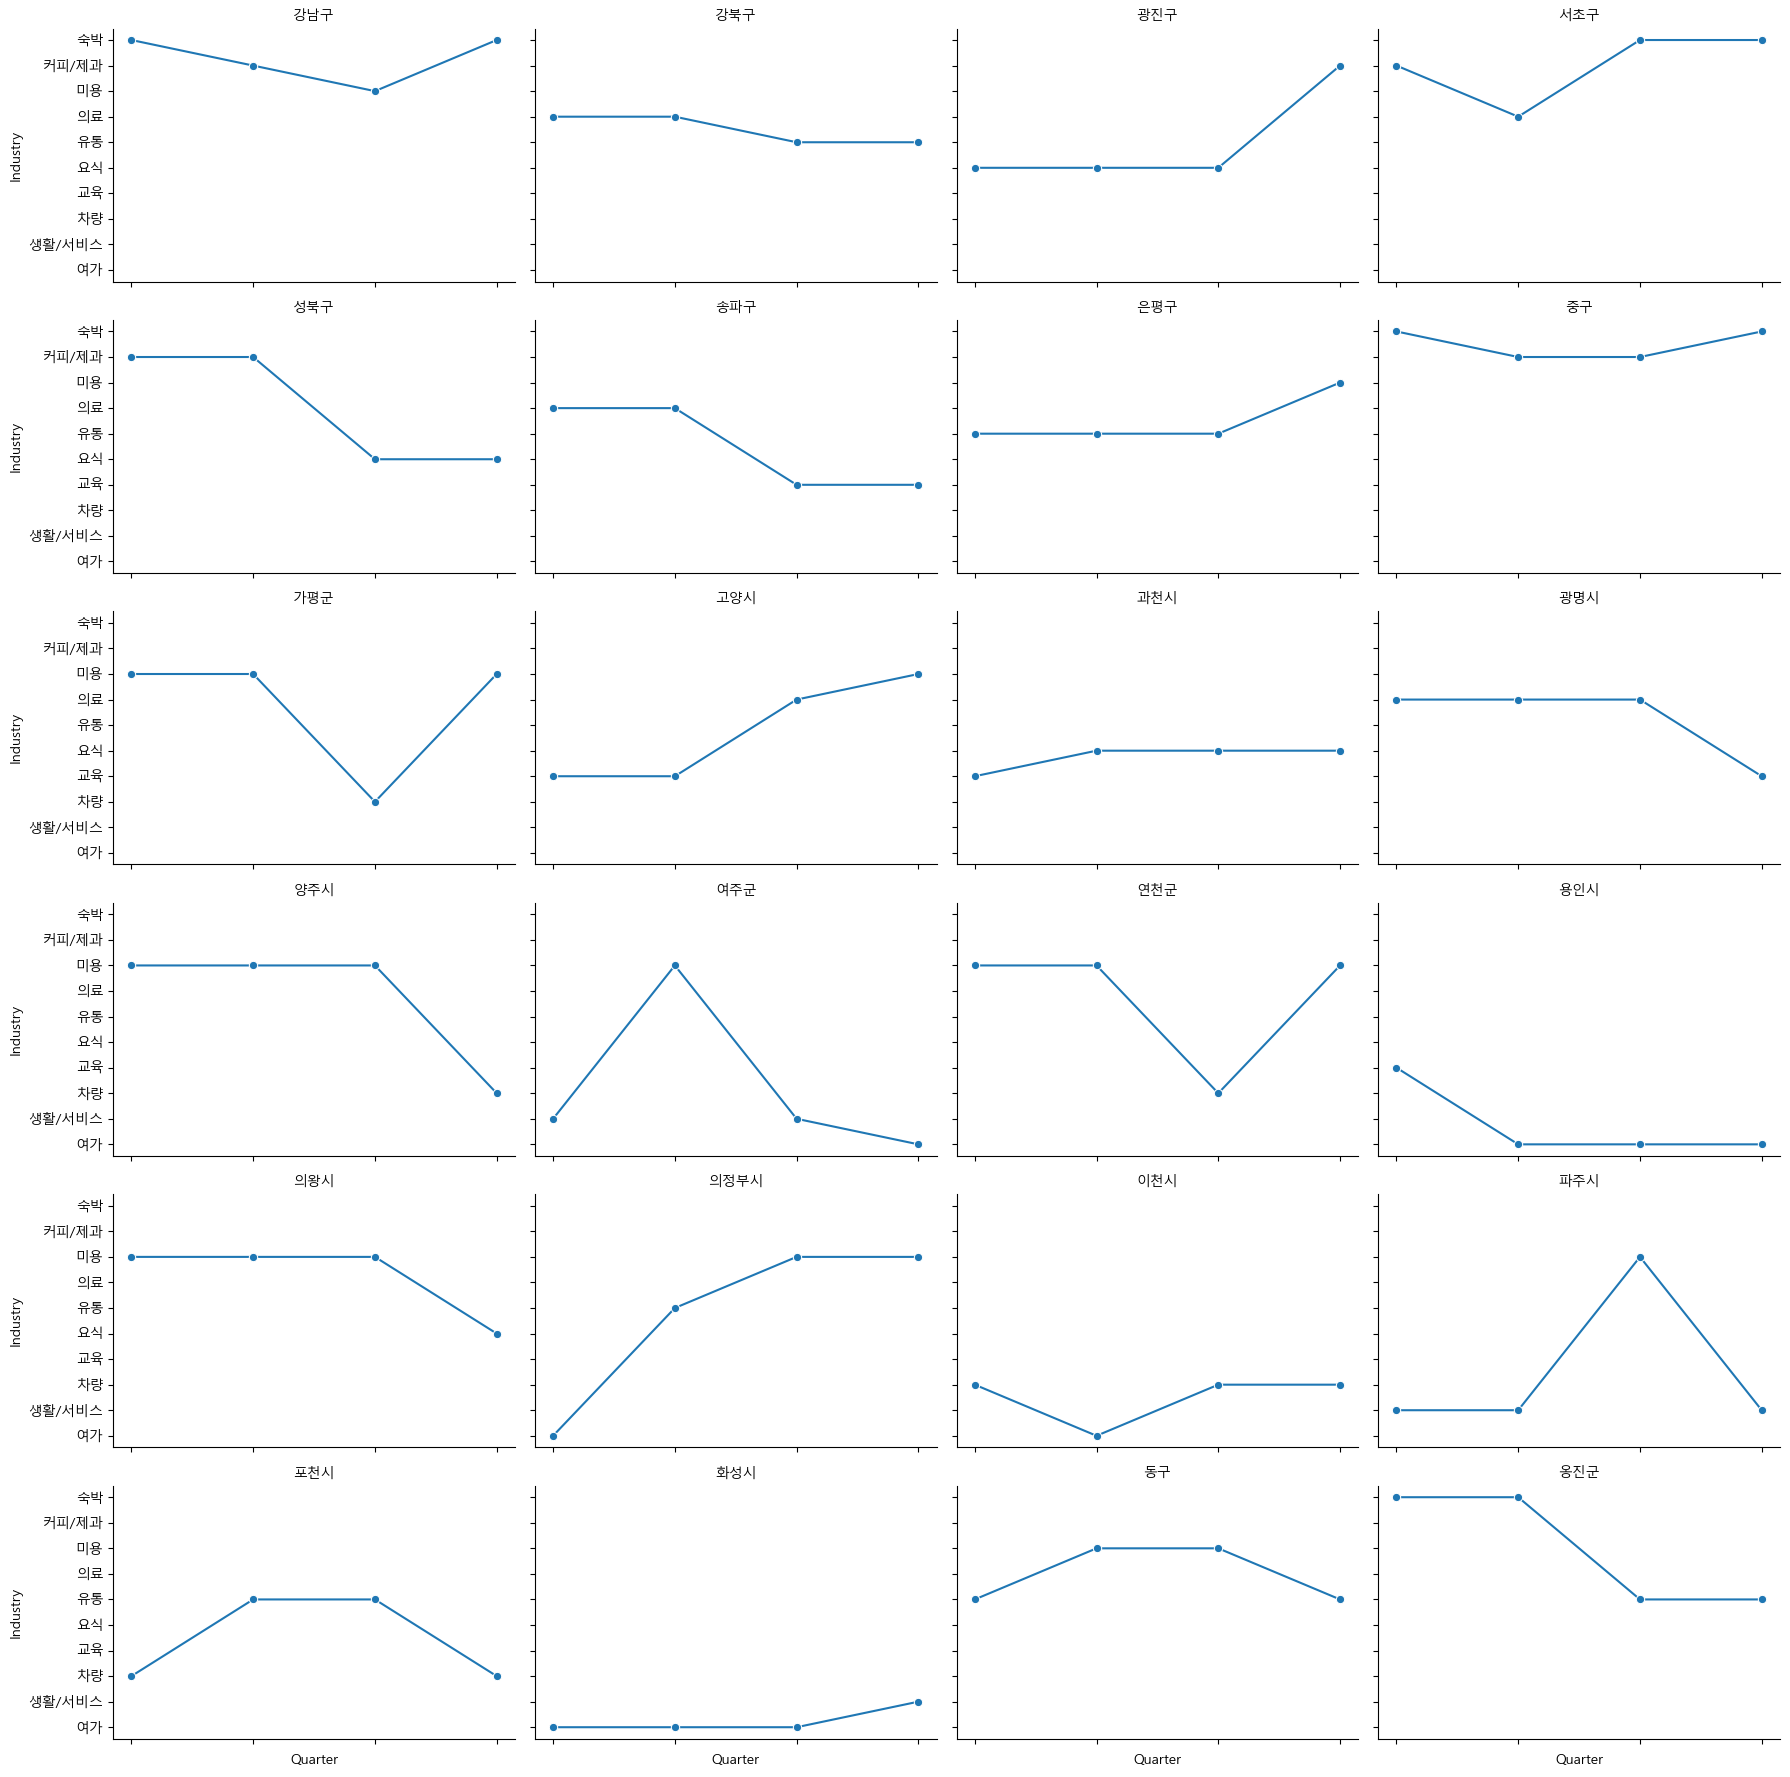

In [67]:
# 분기별로 나눈 지역의 업종변화 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "data/분기별 지역의 업종 변화.xlsx"
seoul_df = pd.read_excel(file_path, sheet_name="Seoul")
gyeonggi_df = pd.read_excel(file_path, sheet_name="Gyeonggi")
incheon_df = pd.read_excel(file_path, sheet_name="Incheon")

# Define a function to transform data into a long format suitable for FacetGrid
def transform_data_for_facetgrid(df):
    df_melted = df.melt(id_vars=["Area"], var_name="Quarter", value_name="Industry")
    return df_melted

# Transform the data for each region
seoul_melted = transform_data_for_facetgrid(seoul_df)
gyeonggi_melted = transform_data_for_facetgrid(gyeonggi_df)
incheon_melted = transform_data_for_facetgrid(incheon_df)

# Combine all data into one DataFrame
combined_df = pd.concat([seoul_melted, gyeonggi_melted, incheon_melted], ignore_index=True)

# Create a FacetGrid
g = sns.FacetGrid(combined_df, col="Area", col_wrap=4, height=3, aspect=1.5)
g.map(sns.lineplot, "Quarter", "Industry", marker="o")

# Set the titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Quarter", "Industry")

# Rotate x-axis labels for better readability
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

C:\Users\ljm31\AppData\Local\Temp\ipykernel_6416\3182048292.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'], rotation=45)


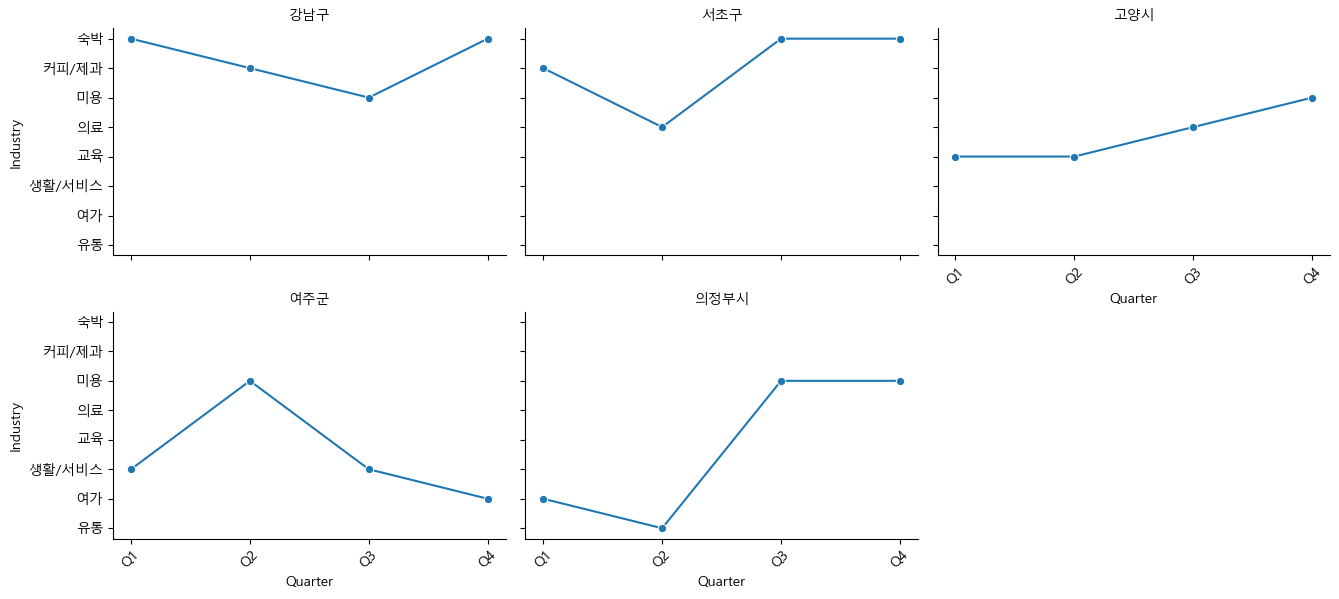

In [79]:
# 자료가 많아서 업종 변화가 3번이상으로 발생한 지역을 선택하여 시각화
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = "data/분기별 지역의 업종 변화.xlsx"
seoul_df = pd.read_excel(file_path, sheet_name="Seoul")
gyeonggi_df = pd.read_excel(file_path, sheet_name="Gyeonggi")
incheon_df = pd.read_excel(file_path, sheet_name="Incheon")

# Define a function to transform data into a long format suitable for FacetGrid
def transform_data_for_facetgrid(df):
    df_melted = df.melt(id_vars=["Area"], var_name="Quarter", value_name="Industry")
    return df_melted

# Transform the data for each region
seoul_melted = transform_data_for_facetgrid(seoul_df)
gyeonggi_melted = transform_data_for_facetgrid(gyeonggi_df)
incheon_melted = transform_data_for_facetgrid(incheon_df)

# Combine all data into one DataFrame
combined_df = pd.concat([seoul_melted, gyeonggi_melted, incheon_melted], ignore_index=True)

# Filter for areas where the industry changes in 3 or more quarters
def filter_areas_with_changes(df):
    change_count = df.groupby('Area')['Industry'].nunique()
    areas_with_changes = change_count[change_count >= 3].index
    return df[df['Area'].isin(areas_with_changes)]

filtered_df = filter_areas_with_changes(combined_df)

# Create a FacetGrid with 3 columns and 2 rows per grid
g = sns.FacetGrid(filtered_df, col="Area", col_wrap=3, height=3, aspect=1.5)
g.map(sns.lineplot, "Quarter", "Industry", marker="o")

# Set the titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Quarter", "Industry")

# Rotate x-axis labels for better readability and set x-axis ticks to show Q1, Q2, Q3, Q4
for ax in g.axes.flatten():
    ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'], rotation=45)

plt.show()
